In [ ]:
import os
import zipfile
import matplotlib.pyplot as plt
import shutil
from shutil import copyfile
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras import Sequential
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img

In [ ]:
local_path = '/content/drive/MyDrive/brain_tumor_data'

In [ ]:
root_path = 'content'

In [ ]:
source_path_no = os.path.join(local_path,'no')
source_path_yes = os.path.join(local_path,'yes')



print(f"there is {len(os.listdir(source_path_no))} of no tumor")
print(f"there is {len(os.listdir(source_path_yes))} of yes tumor")

there is 219 of no tumor
there is 215 of yes tumor


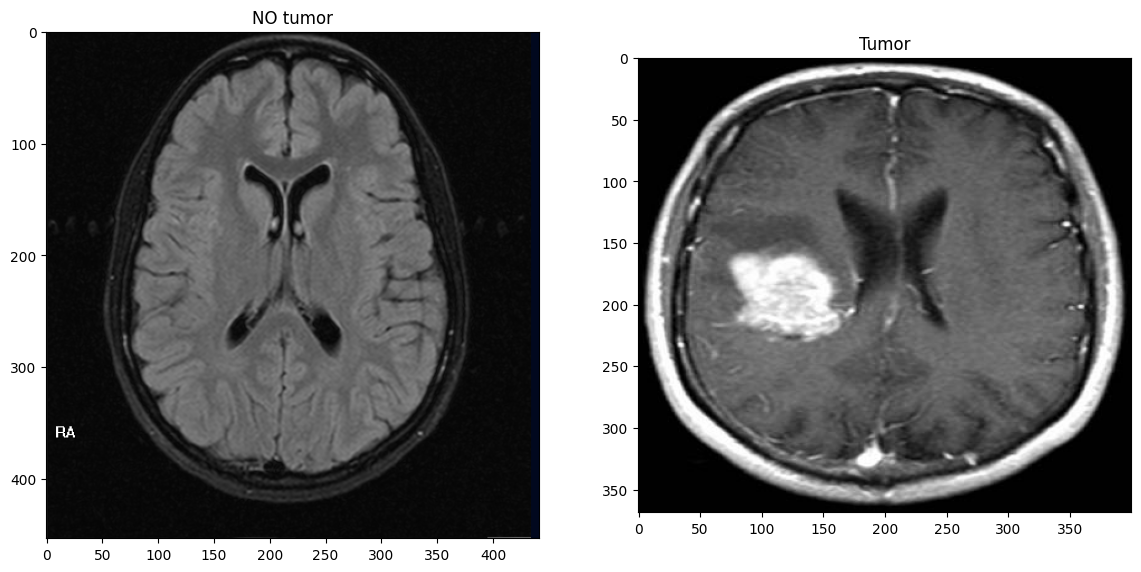

In [ ]:
import cv2

img_yes = cv2.imread(os.path.join(local_path,'yes','Y11.jpg'))
img_no=cv2.imread(os.path.join(local_path,'no','No18.jpg'))

plt.figure(figsize=(14,8))
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img_no,cv2.COLOR_BGR2RGB))
plt.title('NO tumor')
plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(img_yes,cv2.COLOR_BGR2RGB))
plt.title('Tumor')
plt.show()

In [ ]:
# the dataset is so small , we will make data augmentation to generate new instances to increase the size of dataset

In [ ]:
# i've done the augmentation of images multiple times

Text(0.5, 1.0, 'Tumor Photo')

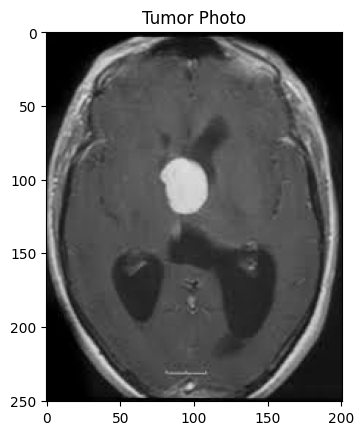

In [ ]:
img_aug = cv2.imread(os.path.join(local_path,'yes','Y254.jpg'))
plt.imshow(img_aug)
plt.title('Tumor Photo')

In [ ]:
def augmentation(source_path, img_aug, number_instances, save_prefix):
  datagen = ImageDataGenerator(
    rotation_range=20,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
    )

  img_aug = img_aug.reshape((1,) + img_aug.shape)  # this is a Numpy array with shape (1, *, *, *)

  i = 0
  for batch in datagen.flow(img_aug, batch_size=1,
                            save_to_dir=source_path, save_prefix= save_prefix, save_format='jpg'):
      i += 1
      if i > number_instances:
          break

In [ ]:
augmentation(source_path_yes, img_aug, 40,'yes_tumor')

In [ ]:
print('Number of images after data augmentation')
print(f"there is {len(os.listdir(source_path_no))} of no tumor")
print(f"there is {len(os.listdir(source_path_yes))} of yes tumor")

Number of images after data augmentation
there is 219 of no tumor
there is 215 of yes tumor


In [ ]:
root_dir = os.path.join(root_path,'temp/yes_no')
os.makedirs(root_dir)

FileExistsError: [Errno 17] File exists: 'content/temp/yes_no'

In [ ]:

if os.path.exists(root_dir):
  shutil.rmtree(root_dir)

def create_train_val_dirs(root_dir):


  training_dir = os.path.join(root_dir,'training')
  validation_dir = os.path.join(root_dir, 'validation')

  os.makedirs(os.path.join(training_dir, "no"))
  os.makedirs(os.path.join(training_dir, "yes"))
  os.makedirs(os.path.join(validation_dir, "yes"))
  os.makedirs(os.path.join(validation_dir, "no"))



try:
  create_train_val_dirs(root_dir=root_dir)
except FileExistsError:
  print("I should not be see this since the upper directory is removed beforehand")

In [ ]:
for rootdir, dirs, files in os.walk(root_dir):
    for subdir in dirs:
        subdir_path = os.path.join(rootdir, subdir)
        print(subdir_path)

content/temp/yes_no/validation
content/temp/yes_no/training
content/temp/yes_no/validation/yes
content/temp/yes_no/validation/no
content/temp/yes_no/training/yes
content/temp/yes_no/training/no


In [ ]:
len(os.listdir(root_dir))

2

In [ ]:
import random


def split_data(SOURCE_DIR, TRAINING_DIR, VALIDATION_DIR, SPLIT_SIZE):

  files = os.listdir(SOURCE_DIR)
  # valid files
  valid_files = [file for file in files if os.path.isfile(os.path.join(SOURCE_DIR, file))]

	# Randomly shuffle the list of valid files
  random.shuffle(valid_files)

    # Calculate the number of files for the training set based on the split size
  num_train_files = int(len(valid_files) * SPLIT_SIZE)

    # Select files for training and validation sets
  train_files = valid_files[:num_train_files]
  val_files = valid_files[num_train_files:]

    # Move files to the training directory
  for file in train_files:
        source_path = os.path.join(SOURCE_DIR, file)
        destination_path = os.path.join(TRAINING_DIR, file)

        if os.path.getsize(source_path) > 0:
          copyfile(source_path, destination_path)
        else:
          print(f"{file}'s is zero length, so ignoring ")

  for file in val_files:
        source_path = os.path.join(SOURCE_DIR, file)
        destination_path = os.path.join(VALIDATION_DIR, file)

        if os.path.getsize(source_path) > 0:
            copyfile(source_path, destination_path)
        else:
            print(f"{file} is zero length, so ignoring.")


In [ ]:
root_dir

'content/temp/yes_no'

In [ ]:
source_path_yes
source_path_no


TRAINING_DIR = '/content/content/temp/yes_no/training'
VALIDATION_DIR = '/content/content/temp/yes_no/validation'

training_yes_dir = os.path.join(TRAINING_DIR, "yes/")
validation_yes_dir = os.path.join(VALIDATION_DIR, "yes/")

training_no_dir = os.path.join(TRAINING_DIR, "no/")
validation_no_dir = os.path.join(VALIDATION_DIR, "no/")


# Empty directories in case you run this cell multiple times
if len(os.listdir(training_yes_dir)) > 0:
  for file in os.scandir(training_yes_dir):
    os.remove(file.path)
if len(os.listdir(training_no_dir)) > 0:
  for file in os.scandir(training_no_dir):
    os.remove(file.path)
if len(os.listdir(validation_yes_dir)) > 0:
  for file in os.scandir(validation_yes_dir):
    os.remove(file.path)
if len(os.listdir(validation_no_dir)) > 0:
  for file in os.scandir(validation_no_dir):
    os.remove(file.path)

split_size = .8

# Run the function
split_data(source_path_yes, training_yes_dir, validation_yes_dir, split_size)
split_data(source_path_no, training_no_dir, validation_no_dir, split_size)


print(f"\n\nOriginal YES's directory has {len(os.listdir(source_path_yes))} images")
print(f"Original NO's directory has {len(os.listdir(source_path_no))} images\n")


print("**************************************************************************")
print(f"There are {len(os.listdir(training_yes_dir))} images of yes tumor for training")
print(f"There are {len(os.listdir(training_no_dir))} images of no tumor for training")
print(f"There are {len(os.listdir(validation_yes_dir))} images of yes tumor for validation")
print(f"There are {len(os.listdir(validation_no_dir))} images of no tumor for validation")



Original YES's directory has 215 images
Original NO's directory has 219 images

**************************************************************************
There are 172 images of yes tumor for training
There are 175 images of no tumor for training
There are 43 images of yes tumor for validation
There are 44 images of no tumor for validation


In [ ]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
  # Instantiate the ImageDataGenerator class (don't forget to set the arguments to augment the images)
  train_datagen = ImageDataGenerator(rescale=.1/255,
                                     rotation_range=40,
                                     width_shift_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest')

  # Pass in the appropriate arguments to the flow_from_directory method
  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=16,
                                                      class_mode='binary',
                                                      target_size=(150, 150))

  # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
  validation_datagen = ImageDataGenerator(rescale=.1/255)

  # Pass in the appropriate arguments to the flow_from_directory method
  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=16,
                                                                class_mode='binary',
                                                                target_size=(150, 150))
  ### END CODE HERE
  return train_generator, validation_generator

In [ ]:
train_generator, validation_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR)

Found 347 images belonging to 2 classes.
Found 87 images belonging to 2 classes.


In [ ]:
print(train_generator.class_indices)

{'no': 0, 'yes': 1}


In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

def create_model():

  model = Sequential()

  model.add(layers.Conv2D(1024, (3, 3), activation='relu', input_shape=(150, 150, 3)))
  model.add(layers.MaxPooling2D((2, 2)))

  model.add(layers.Conv2D(512, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))


  model.add(Flatten())
  model.add(Dense(32, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))


  learning_rate = 0.001
  optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

  model.compile(optimizer=optimizer,
                loss='binary_crossentropy',
                metrics=['accuracy'])


  return model

In [ ]:
model = create_model()

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 148, 148, 1024)    28672     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 74, 74, 1024)      0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 72, 72, 512)       4719104   
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 36, 36, 512)       0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 663552)            0         
                                                                 
 dense_2 (Dense)             (None, 32)               

In [ ]:
history = model.fit(train_generator,
                    epochs=10,
                    verbose = 2,
                    validation_data=validation_generator)

Epoch 1/10
22/22 - 37s - loss: 0.6917 - accuracy: 0.5216 - val_loss: 0.6915 - val_accuracy: 0.5057 - 37s/epoch - 2s/step
Epoch 2/10
22/22 - 6s - loss: 0.6931 - accuracy: 0.5043 - val_loss: 0.6859 - val_accuracy: 0.5057 - 6s/epoch - 282ms/step
Epoch 3/10
22/22 - 6s - loss: 0.6755 - accuracy: 0.5043 - val_loss: 0.6537 - val_accuracy: 0.5057 - 6s/epoch - 290ms/step
Epoch 4/10
22/22 - 7s - loss: 0.6372 - accuracy: 0.6628 - val_loss: 0.5508 - val_accuracy: 0.7126 - 7s/epoch - 296ms/step
Epoch 5/10
22/22 - 6s - loss: 0.6274 - accuracy: 0.6888 - val_loss: 0.4942 - val_accuracy: 0.7241 - 6s/epoch - 290ms/step
Epoch 6/10
22/22 - 7s - loss: 0.5839 - accuracy: 0.6945 - val_loss: 0.5797 - val_accuracy: 0.7126 - 7s/epoch - 298ms/step
Epoch 7/10
22/22 - 7s - loss: 0.5452 - accuracy: 0.7378 - val_loss: 0.5054 - val_accuracy: 0.7011 - 7s/epoch - 301ms/step
Epoch 8/10
22/22 - 6s - loss: 0.5215 - accuracy: 0.7233 - val_loss: 0.4608 - val_accuracy: 0.8161 - 6s/epoch - 295ms/step
Epoch 9/10
22/22 - 6s - l

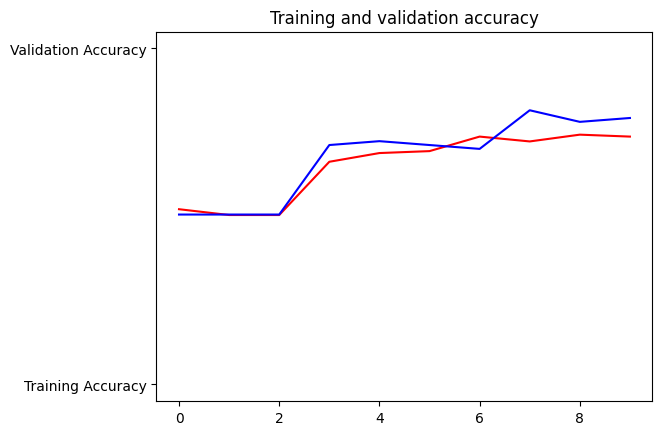

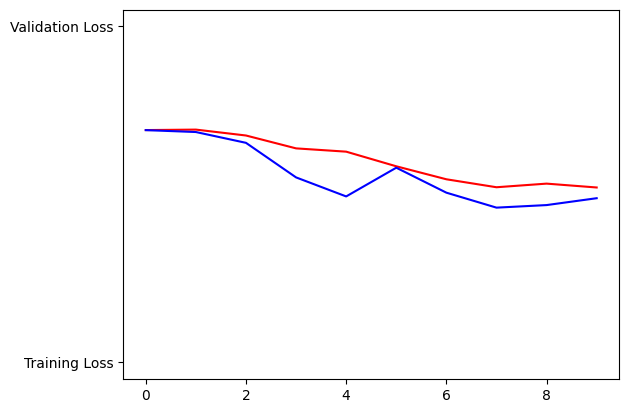

In [ ]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.show()

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2024-01-23 14:13:22--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.10.207, 142.251.12.207, 172.217.194.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.10.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  22.4MB/s    in 5.0s    

2024-01-23 14:13:27 (16.7 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [ ]:

# Import the inception model
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [ ]:

def create_pre_trained_model(local_weights_file):

  pre_trained_model = InceptionV3(input_shape = (150, 150, 3),
                                  include_top = False,
                                  weights = None)

  pre_trained_model.load_weights(local_weights_file)

  for layer in pre_trained_model.layers:
    layer.trainable = False


  return pre_trained_model

In [ ]:
pre_trained_model = create_pre_trained_model(local_weights_file)

# Choose `mixed7` as the last layer of your base model
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [ ]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

# Append the dense network to the base model
model_pre = Model(pre_trained_model.input, x)

# Print the model summary. See your dense network connected at the end.
#model_pre.summary()


# Set the training parameters
model_pre.compile(optimizer = RMSprop(learning_rate=0.0001),
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

In [ ]:
history = model_pre.fit(
            train_generator,
            validation_data = validation_generator,
            epochs = 10,
            verbose = 2)

Epoch 1/10
22/22 - 13s - loss: 0.7524 - accuracy: 0.6830 - val_loss: 0.2598 - val_accuracy: 0.9195 - 13s/epoch - 577ms/step
Epoch 2/10
22/22 - 3s - loss: 0.3662 - accuracy: 0.8444 - val_loss: 0.2463 - val_accuracy: 0.8851 - 3s/epoch - 115ms/step
Epoch 3/10
22/22 - 3s - loss: 0.3886 - accuracy: 0.8242 - val_loss: 0.1382 - val_accuracy: 0.9540 - 3s/epoch - 122ms/step
Epoch 4/10
22/22 - 3s - loss: 0.2636 - accuracy: 0.8934 - val_loss: 0.3589 - val_accuracy: 0.7931 - 3s/epoch - 119ms/step
Epoch 5/10
22/22 - 4s - loss: 0.2630 - accuracy: 0.9107 - val_loss: 0.2632 - val_accuracy: 0.8621 - 4s/epoch - 196ms/step
Epoch 6/10
22/22 - 3s - loss: 0.2250 - accuracy: 0.9222 - val_loss: 0.1487 - val_accuracy: 0.9655 - 3s/epoch - 145ms/step
Epoch 7/10
22/22 - 3s - loss: 0.2750 - accuracy: 0.8991 - val_loss: 0.2319 - val_accuracy: 0.8851 - 3s/epoch - 118ms/step
Epoch 8/10
22/22 - 3s - loss: 0.2320 - accuracy: 0.9164 - val_loss: 0.3124 - val_accuracy: 0.8736 - 3s/epoch - 117ms/step
Epoch 9/10
22/22 - 3s 

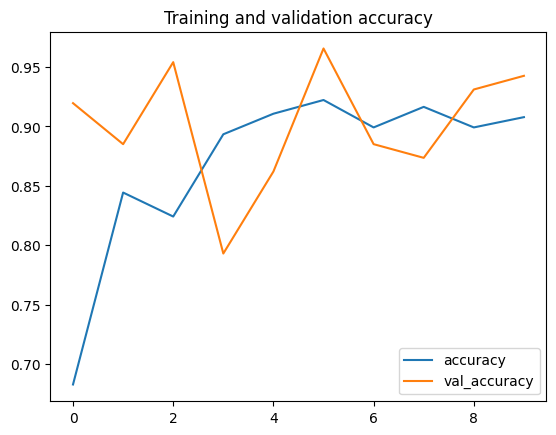

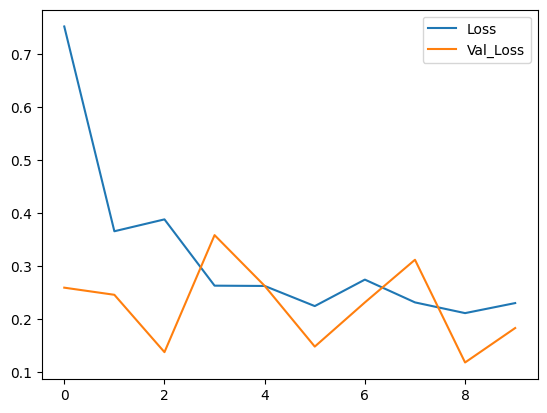

In [ ]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(acc, label='accuracy')
plt.plot(val_acc, label= 'val_accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(loss, label='Loss')
plt.plot(val_loss , label='Val_Loss')
plt.legend()
plt.show()

In [ ]:
img_test = image.load_img('/content/content/temp/yes_no/training/no/15 no.jpg',target_size=(150, 150))
img_test = image.img_to_array(img_test)
img_test.shape

(150, 150, 3)

# Test on a Tumor

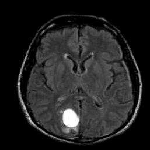

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions

img_path = '/content/test_image.png'
img = image.load_img(img_path, target_size=(150, 150))
img

In [ ]:
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

In [ ]:
predictions = model_pre.predict(img_array)

1/1 [==============================] - 2s 2s/step


In [ ]:
predictions

array([[0.57734036]], dtype=float32)

In [ ]:
if predictions > 0.5:
  print('There is a Tumor in the brain')
else:
  print('There is no tumor, begnin picture ')

There is a Tumor in the brain


#test no img

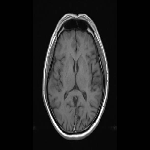

In [ ]:
img_path = '/content/test_no_img.jpg'
img = image.load_img(img_path, target_size=(150, 150))
img

In [ ]:
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

In [ ]:
new_predictions = model_pre.predict(img_array)

1/1 [==============================] - 0s 23ms/step


In [ ]:
new_predictions

array([[0.0090002]], dtype=float32)

In [ ]:
if new_predictions > 0.5:
  print('There is a Tumor in the brain')
else:
  print('There is no tumor, begnin picture ')

There is no tumor, begnin picture 
